# **1. Preâmbulo**

O que veremos?

- Implementação de técnicas de PDI baseadas em histogramas

- Lembre-se de **salvar** de tempos em tempos seu Notebook.

## **1.1 Importações e path**

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

os.chdir('/content/drive/MyDrive/2023 1/PDI/Notebooks-aulas/Histogramas/')

## **1.2 Funções auxiliares**

- Ver notebooks de aulas anteriores

In [2]:
# tipos: 'b' --> básico, 'p' --> probabilidades, 'c' --> cdf
def histograma(img, tipo='p'):
  arr = np.asarray(img).astype(int)

  arrCinza = np.dot(arr, np.array([0.299, 0.587, 0.144]).T)
  arrCinza = arrCinza.round().astype(int).clip(0,255) # clip poda valores dentro dos limites

  # Histograma básico
  H = np.zeros((4, 256)) # 3 canais + cinza x 256 níveis de intensidade

  for k in range(256):
    for c in range(3):
      H[c,k] = (arr[:,:,c] == k).sum()
    H[3,k] = (arrCinza == k).sum() # Contagem no nível k em cinza

  if tipo == 'b':
    return H

  # Histograma de probabilidades
  H /= arr.shape[0]*arr.shape[1]

  if tipo == 'p':
    return H

  # Histograma de probabilidades acumuladas (CDF)
  CDF = np.zeros_like(H)
  for k in range(256):
    soma = np.sum(H[:, :k+1], axis=1)
    CDF[:,k] = soma

  # Alternativa:
  # CDF = np.cumsum(H, axis=1)

  return CDF

In [3]:
def plot_histograma_individual(h, canal='Cinza', tipo='de Probabilidades'):
  x = np.arange(0, 256)
  plt.bar(x, h)
  plt.title('Histograma %s do canal %s' % (tipo, canal))
  plt.xlabel('Níveis')
  plt.ylabel('Ocorrências')
  plt.tight_layout()
  plt.show()

In [4]:
def plot_histogramas(H, titulos):
  assert isinstance(H, list)
  assert isinstance(titulos, list)
  assert len(H) == len(titulos)

  # Cria um vetor com os níveis de intensidade (k)
  k = np.arange(0, 256)

  fig, ax = plt.subplots(nrows=1, ncols=len(H), figsize=(24,6))

  # Para cada histograma, cria um subplot
  for c in range(len(H)):
    ax[c].bar(k, H[c])
    ax[c].set(title=titulos[c])
    ax[c].set(xlabel='Níveis')
    ax[c].set(ylabel='Ocorrências')

  # Ajustes finais e exibição
  plt.suptitle('Histogramas')
  plt.show()

In [5]:
def gera_imagem(arr):
  arrImg = arr.round().clip(0,255).astype(np.uint8)
  return Image.fromarray(arrImg)

In [6]:
def cinza_lum(obj):
  T = np.array([0.299, 0.587, 0.144]).T

  if not isinstance(obj, np.ndarray):
    arr = np.asarray(obj).astype(int)
  else:
    arr = obj.copy()

  return np.dot(arr, T)

In [7]:
def redim(img, fator):
  novaAltura = round(img.height * fator)
  novaLargura = round(img.width * fator)

  return img.resize((novaLargura, novaAltura))

In [8]:
def exibe_mosaico(imagens, legendas, colunas=4, arquivo=None):
  # Largura e altura básicos, de referência, das imagens
  l = 8
  a = 6

  n_imagens = len(imagens)
  if len(imagens) < colunas:
    colunas = len(imagens)
  linhas = n_imagens // colunas + int(n_imagens % colunas > 0)

  fig = plt.figure(figsize=(l*colunas,a*linhas))
  ax = []

  i = j = 0
  for pos, img in enumerate(imagens):
    i = pos // colunas
    j = pos % colunas
    ax.append(fig.add_subplot(linhas, colunas, pos+1))
    ax[-1].axis('off')
    if img.mode == 'L' or img.mode == '1':
      img = img.convert('RGB')
    arr = np.asarray(img)
    ax[-1].imshow(arr)
    ax[-1].set_title(legendas[pos])

  fig.tight_layout()

  if arquivo is not None:
    plt.savefig(arquivo, dpi=300)
    
  plt.show()

# **2. Equalização de Histogramas**

1. Carregando uma imagem com problemas de contraste

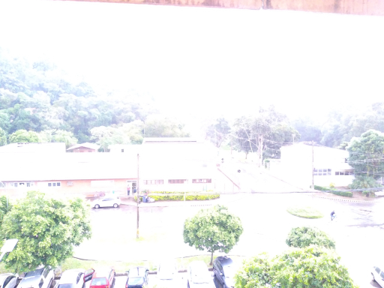

In [9]:
img = Image.open('ufv-estourada.jpg')
img = redim(img, 0.75)
display(img)

2. Obtendo os histogramas de probabilidades e probabilidades acumuladas

In [11]:
C = histograma(img, tipo='c')

# Sigma será substituído por C (já calculado)

3. Com os histogramas CDF já calculados, o primeiro laço do algoritmo terá apenas o mapeamento. Aqui, não implementaremos usando laços, mas sim explorando os recursos da biblioteca `numpy`

In [12]:
s = 255 * C
s = s.round().astype(int)

4. Aplicação do mapeamento na imagem de saída

In [13]:
# Cria uma imagem de saída com mesmo formato da imagem de entrada
arr = np.asarray(img).astype(int)
arrEq = np.zeros_like(arr)

# Para visualizarmos a equalização sobre os tons de cinza, vamos criar as estruturas:
arrCinza = cinza_lum(img)
imgCinza = gera_imagem(arrCinza)
arrCinza = arrCinza.round().clip(0,255).astype(int)
arrCinzaEq = np.zeros_like(arrCinza)

# Aplica o mapeamento
for i in range(arr.shape[0]):
  for j in range(arr.shape[1]):
    r,g,b = arr[i,j]
    c = arrCinza[i,j]

    arrEq[i,j] = [s[0,r], s[1,g], s[2,b]]
    arrCinzaEq[i,j] = s[3,c]

5. Visualizando os resultados

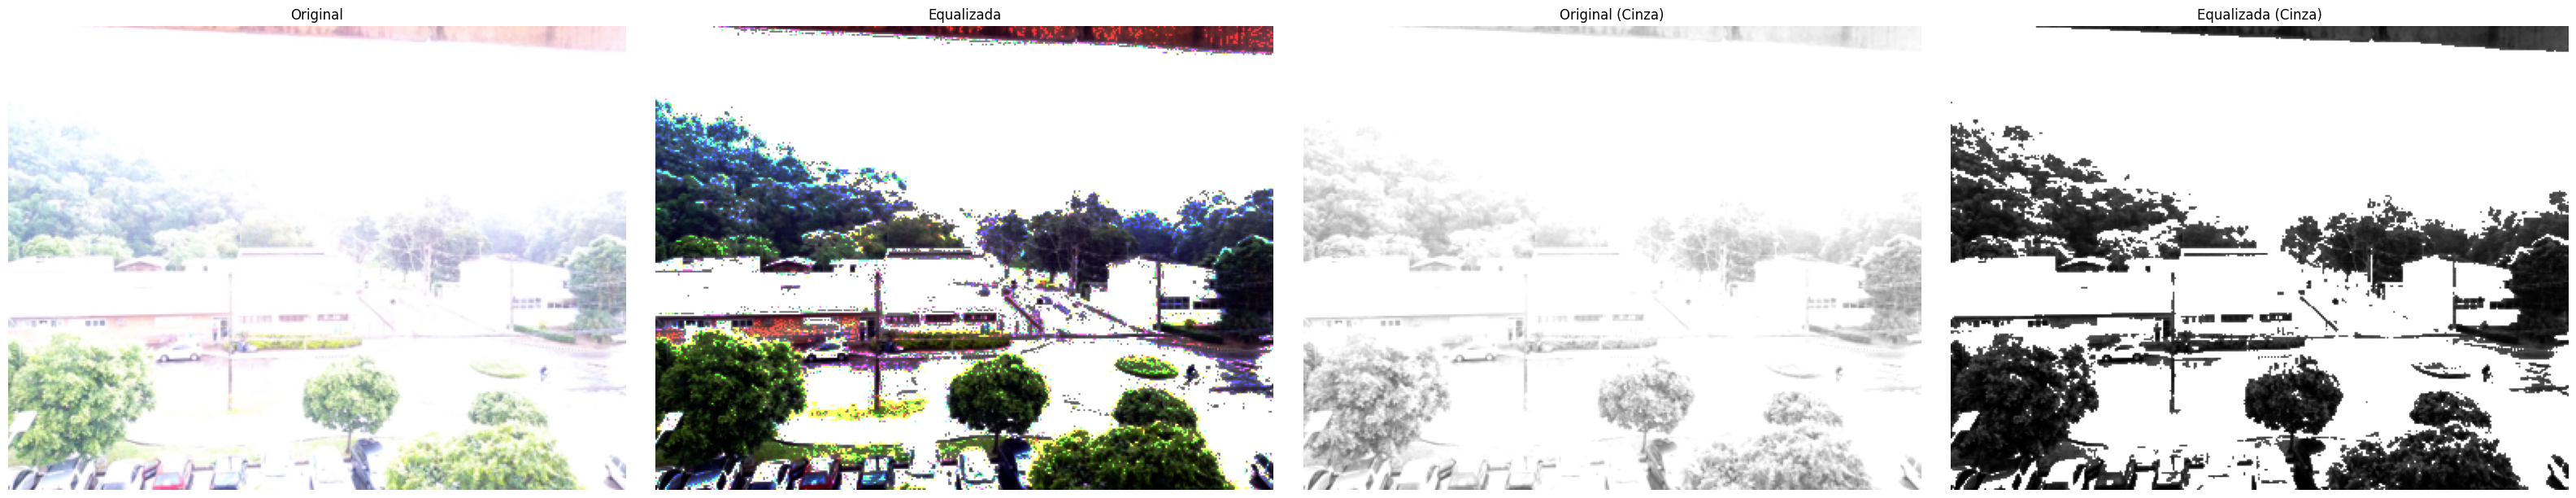

In [14]:
imgEq = gera_imagem(arrEq)
imgCinzaEq = gera_imagem(arrCinzaEq)

imgs = [img, imgEq, imgCinza, imgCinzaEq]
legendas = ['Original', 'Equalizada', 'Original (Cinza)', 'Equalizada (Cinza)']
exibe_mosaico(imgs, legendas)

### **2.1 O que está acontecendo?**

Vamos analisar os efeitos dos passos dados sobre o histograma das imagens.

Para fins de simplicidade, vamos analisar os histogramas da versão em tons de cinza apenas.

1. Histogramas Originais

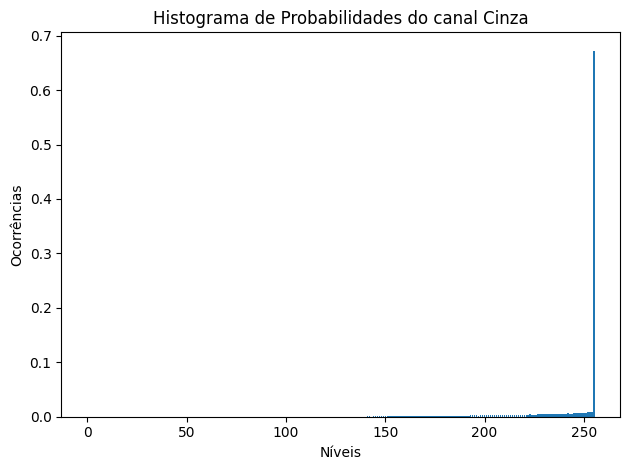

In [15]:
P = histograma(img, tipo='p')
plot_histograma_individual(P[3])

- Note as ocorrências de pixels concentradas na faixa de níveis mais altos de intensidade
- Note, também, que tais pixels estão concentrados em um pequeno intervalo
- Esta última característica é o que se tem quando se trabalha com uma imagem de contraste ruim

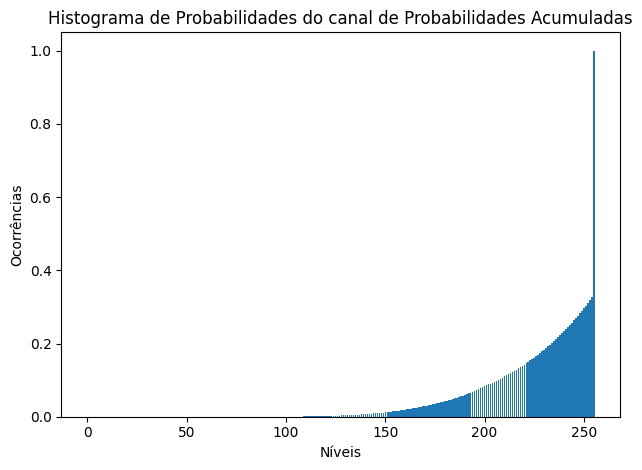

In [16]:
plot_histograma_individual(C[3], 'de Probabilidades Acumuladas')

2. Mapeamento

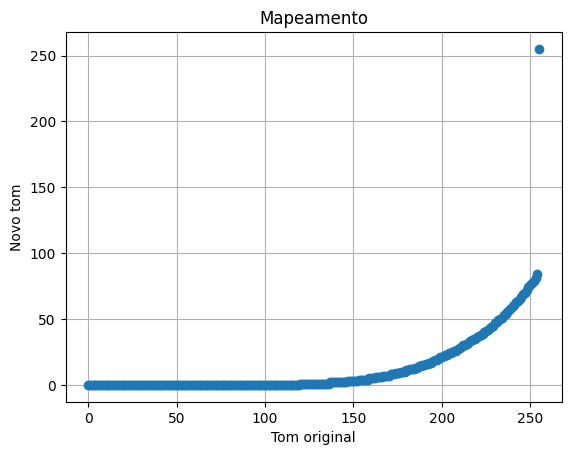

In [17]:
s = 255 * C[3]
s = s.round().astype(int)

plt.title('Mapeamento')
k = np.arange(len(s))
plt.plot(k, s, 'o')
plt.xlabel('Tom original')
plt.ylabel('Novo tom')
plt.grid()
plt.show()

- O histograma CDF é normalizado em $[0,1]$
- Multiplicar por $255$ significa espalhar, ao longo do eixo dos níveis de intensidade, os valores do histograma original, de forma proporcional à probabilidade de ocorrência daquele tom
- Por exemplo, se a CDF relativa a um tom $k$ qualquer é $0.2$, significa que $20\%$ dos pixels da imagem possuem valores até $k$. No mapeamento, vamos mapear $k$ para $0.2 \cdot 255 = 51$, que corresponde a $20\%$ do intervalo $[0,255]$

3. Aplicação do mapeamento e histograma resultante

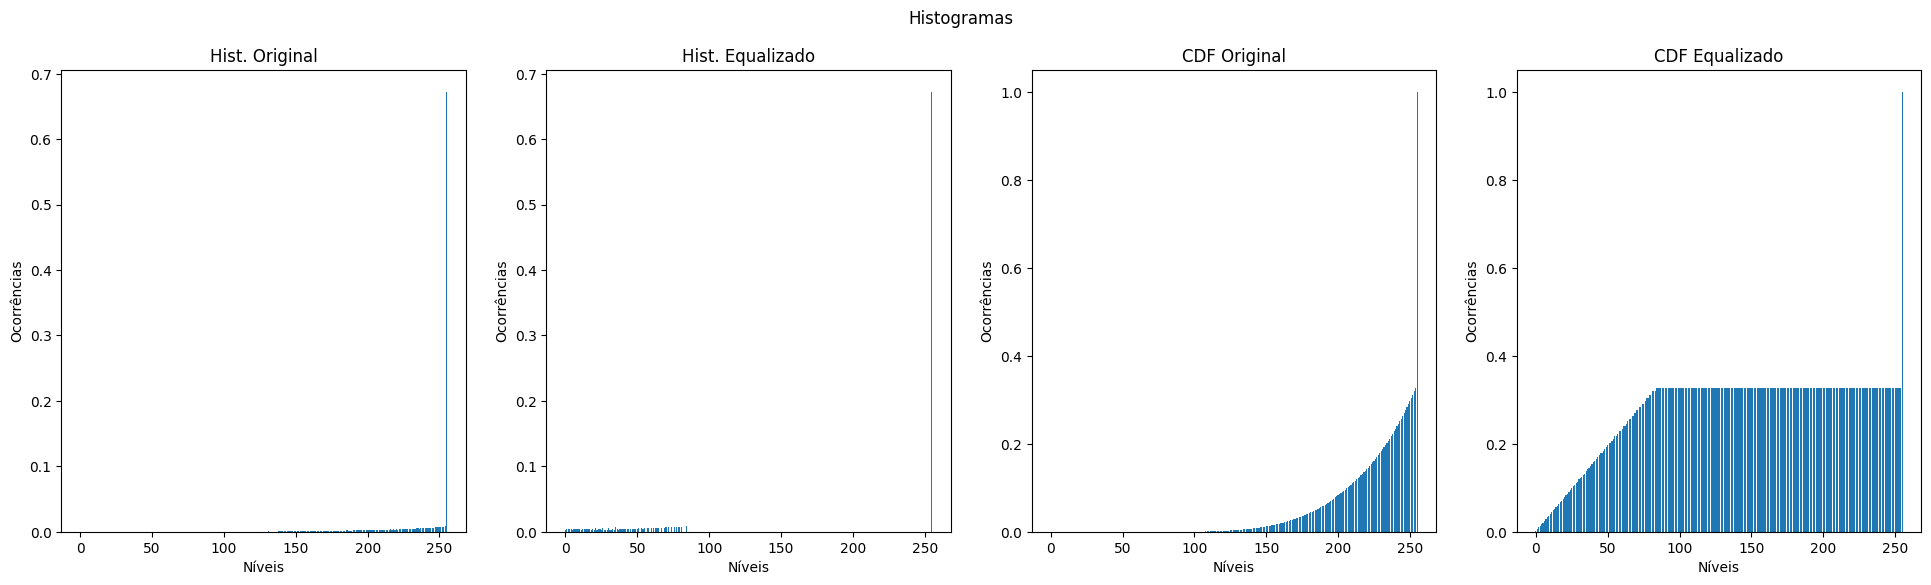

In [18]:
# Cria imagens moncromáticas, mas no padrão RGB
arrCinza_ = np.dstack((arrCinza, arrCinza, arrCinza))
arrCinzaEq_ = np.dstack((arrCinzaEq, arrCinzaEq, arrCinzaEq))

# Calcula os histogramas (e extrai um canal apenas)
P_ = histograma(arrCinza_, tipo='p')[0]
C_ = histograma(arrCinza_, tipo='c')[0]
Peq_ = histograma(arrCinzaEq_, tipo='p')[0]
Ceq_ = histograma(arrCinzaEq_, tipo='c')[0]

H = [P_, Peq_, C_, Ceq_]
titulos = ['Hist. Original', 'Hist. Equalizado', 'CDF Original', 'CDF Equalizado']
plot_histogramas(H, titulos)

- Note o espalhamento dos histogramas ao longo do eixo $k$, dos níveis de intensidade

- Vejamos agora o exemplo aplicado a outras imagens. Primeiro, vamos condensar tudo em uma função, para facilitar:

In [19]:
def equaliza_histograma(img):
  arr = np.asarray(img).astype(int)

  P = histograma(img, tipo='p')
  C = histograma(img, tipo='c')

  s = 255 * C
  s = s.round().astype(int)

  arrEq = np.zeros_like(arr)
  for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
      pixmap = []
      for c in range(arr.shape[2]):
        pixmap.append(s[c, arr[i,j,c]])
      arrEq[i,j] = np.array(pixmap)

  return gera_imagem(arrEq)

In [20]:
arquivos = [
    'ufv_escuro.jpg',
    'ufv_crepusculo.png',
    'ufv_claro.jpg',
    'ufv_noite.jpg',
    'praia_ruim.png',
    'orquideaRuim.jpg'
    ]

imgs = []
legs = []
for arq in arquivos:
  img = Image.open(arq)
  imgs.append(img)
  legs.append(arq)

  imgEq = equaliza_histograma(img)
  imgs.append(imgEq)
  legs.append(arq + ' equalizada')

exibe_mosaico(imgs, legs)

Output hidden; open in https://colab.research.google.com to view.

## **2.2 Método alternativo: alargamento de contraste**

- Vimos que a equalização de histograma consiste em dispersar os tons dos pixels da imagem seguindo o histograma CDF como "guia" para o espalhamento. Isto é, fazemos a dispersão de forma proporcional ao CDF do tom desejado

- O Alargamento de Contraste utiliza uma ideia similar, porém não usa histogramas. A idéia básica consiste em:

  1. Normalizar os valores de intensidade dos pixels no intervalo $[0,1]$
  2. Remapear os valores normalizados para o intervalo $[0,255]$

- Desta maneira, os tons serão espalhados ao longo do eixo $k$, porém de forma proporcional à distribuição (histograma) original dos dados, não mais a CDF.

- Vamos implementar a ideia em uma função:

In [21]:
def alarga_contraste(img):
  arr = np.asarray(img).astype(int)

  # Normaliza (por canal)
  kMin = arr.min(axis=0).min(axis=0)
  kMax = arr.max(axis=0).max(axis=0)
  arr = (arr - kMin) / (kMax - kMin)

  # Remapeia
  arr *= 255

  return gera_imagem(arr)

- Vamos comparar as duas técnicas. Primeiro, o resultado visual:

In [22]:
arquivos = [
    'ufv_escuro.jpg',
    'ufv_crepusculo.png',
    'ufv_claro.jpg',
    'ufv_noite.jpg',
    'praia_ruim.png',
    'orquideaRuim.jpg'
    ]

imgs = []
legs = []
for arq in arquivos:
  img = Image.open(arq)
  imgs.append(img)
  legs.append(arq)

  imgEq = equaliza_histograma(img)
  imgs.append(imgEq)
  legs.append(arq + ' equalizada')

  imgAlarg = alarga_contraste(img)
  imgs.append(imgAlarg)
  legs.append(arq + ' alarg. contraste')

exibe_mosaico(imgs, legs, colunas=3)

Output hidden; open in https://colab.research.google.com to view.

- Note as diferenças entre as imagens produzidas. Dependendo do contexto, uma técnica pode ser mais aconselhável que a outra

- Vejamos, agora, as diferenças em relação ao que acontece com o histograma, em cada caso.

In [23]:
# Abre as duas imagens e aplica as técnicas
imgPr = Image.open('praia_ruim.png')
imgUfv = Image.open('ufv_escuro.jpg')

imgPrEq = equaliza_histograma(imgPr)
imgUfvEq = equaliza_histograma(imgUfv)

imgPrAl = alarga_contraste(imgPr)
imgUfvAl = alarga_contraste(imgUfv)

# Computa histograma das imagens originais (e extrai apenas o canal cinza)
Ppr = histograma(imgPr, tipo='p')[3]
Cpr = histograma(imgPr, tipo='c')[3]
Pufv = histograma(imgUfv, tipo='p')[3]
Cufv = histograma(imgUfv, tipo='c')[3]

# Computa histograma das imagens equalizadas (e extrai apenas o canal cinza)
PprEq = histograma(imgPrEq, tipo='p')[3]
CprEq = histograma(imgPrEq, tipo='c')[3]
PufvEq = histograma(imgUfvEq, tipo='p')[3]
CufvEq = histograma(imgUfvEq, tipo='c')[3]

# Computa histograma das imagens com contraste alargado (e extrai apenas o canal cinza)
PprAl= histograma(imgPrAl, tipo='p')[3]
CprAl = histograma(imgPrAl, tipo='c')[3]
PufvAl = histograma(imgUfvAl, tipo='p')[3]
CufvAl = histograma(imgUfvAl, tipo='c')[3]

- Vamos, agora, comparar os resultados de cada técnica, em cada caso

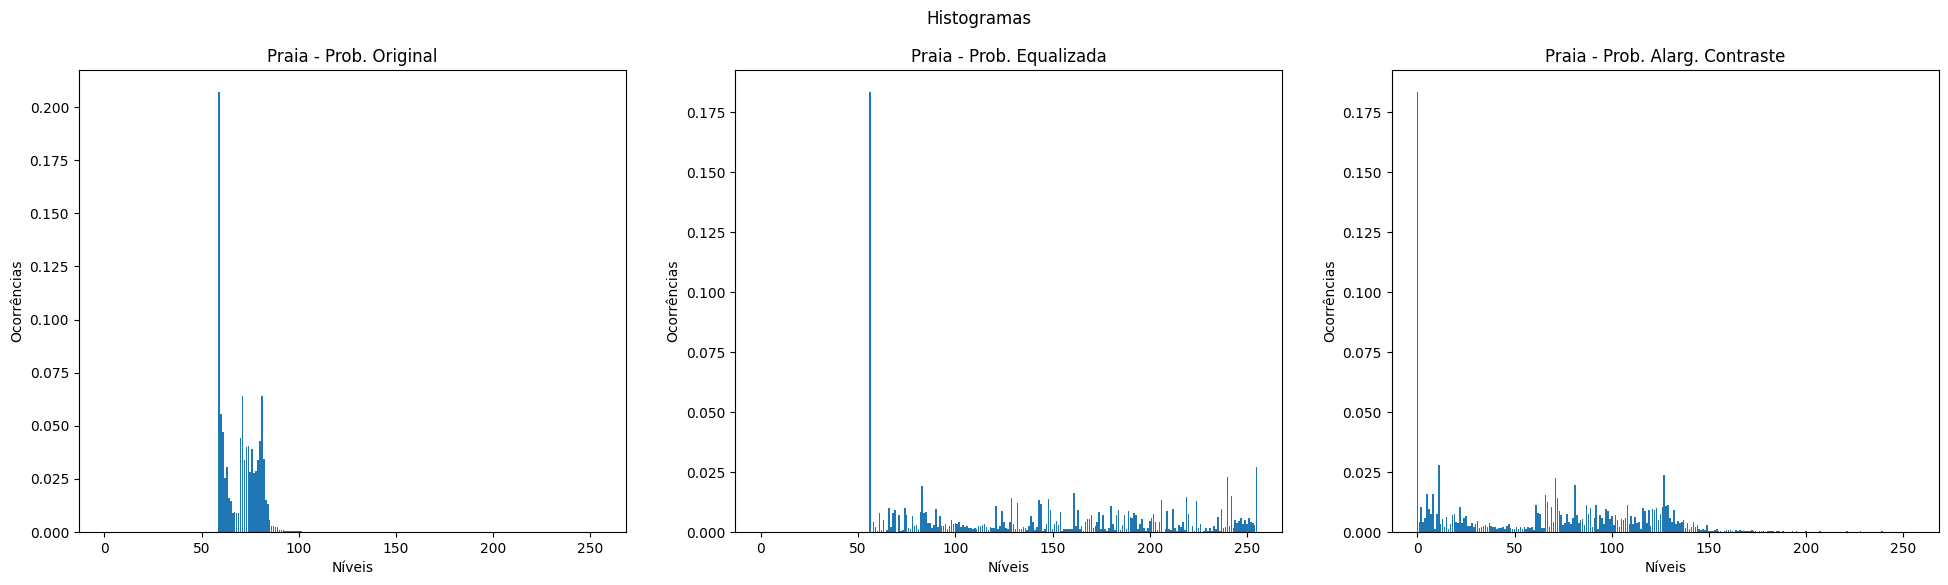

In [24]:
H = [Ppr, PprEq, PprAl]
titulos = ['Praia - Prob. Original', 'Praia - Prob. Equalizada', 'Praia - Prob. Alarg. Contraste']
plot_histogramas(H, titulos)

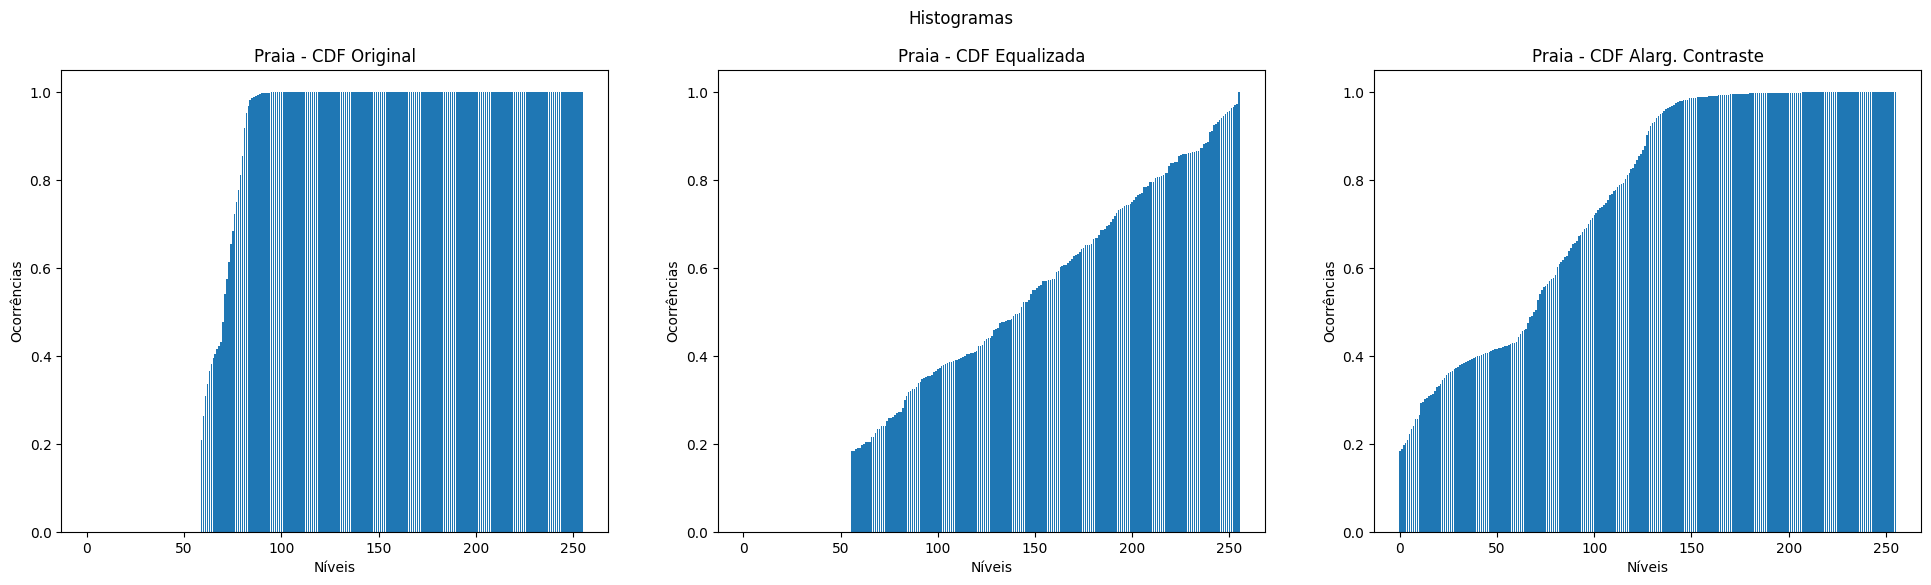

In [25]:
C = [Cpr, CprEq, CprAl]
titulos = ['Praia - CDF Original', 'Praia - CDF Equalizada', 'Praia - CDF Alarg. Contraste']
plot_histogramas(C, titulos)

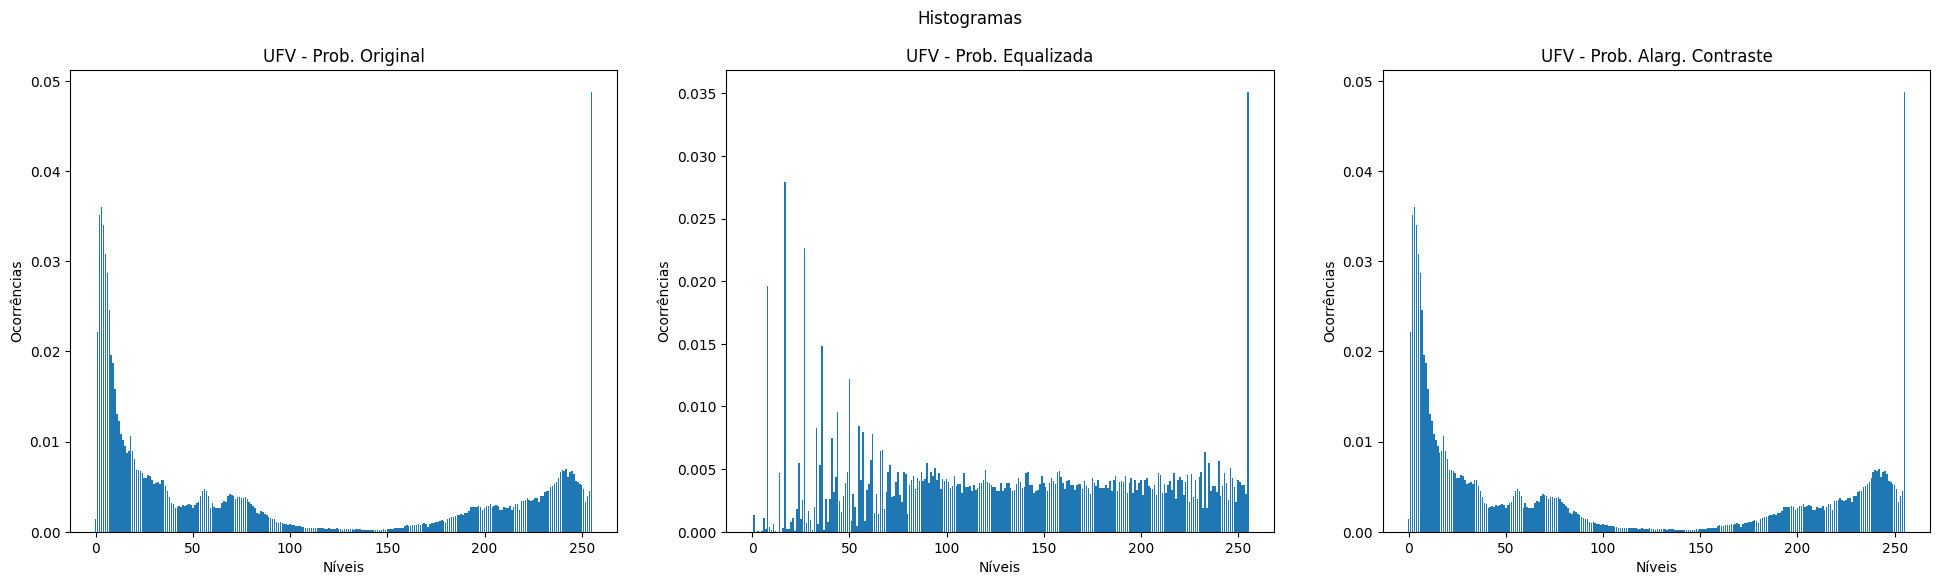

In [26]:
H = [Pufv, PufvEq, PufvAl]
titulos = ['UFV - Prob. Original', 'UFV - Prob. Equalizada', 'UFV - Prob. Alarg. Contraste']
plot_histogramas(H, titulos)

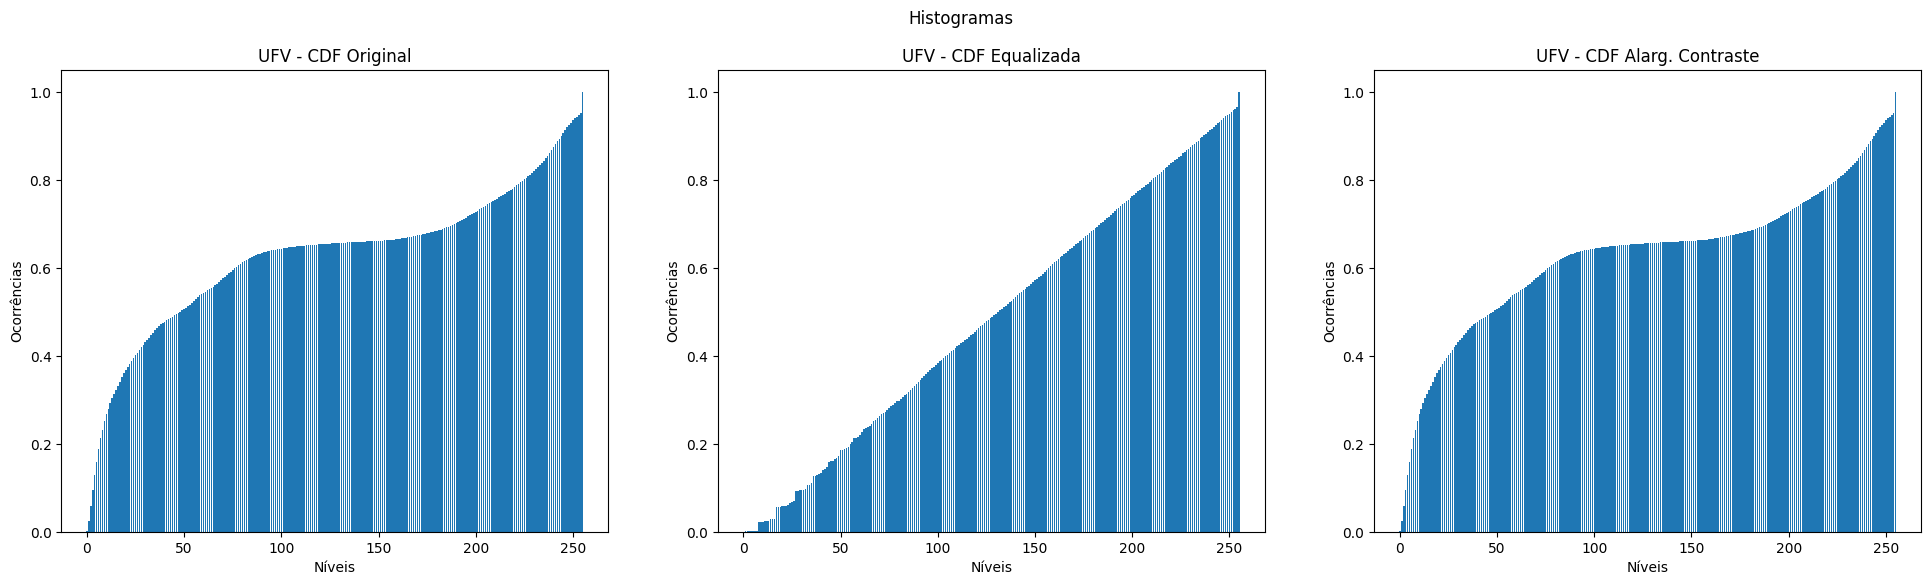

In [27]:
C = [Cufv, CufvEq, CufvAl]
titulos = ['UFV - CDF Original', 'UFV - CDF Equalizada', 'UFV - CDF Alarg. Contraste']
plot_histogramas(C, titulos)

- Note que, na segunda imagem, como os pixels da imagem original já eram distribuídos sobre todo o eixo $k$, alargar seu contraste não surte muito efeito

# **3. Especificação Direta de Histogramas**

Nesta seção, vamos trabalhar sempre com um par de imagens. Uma cederá a forma e a outra o padrão de cores para a imagem resultante.

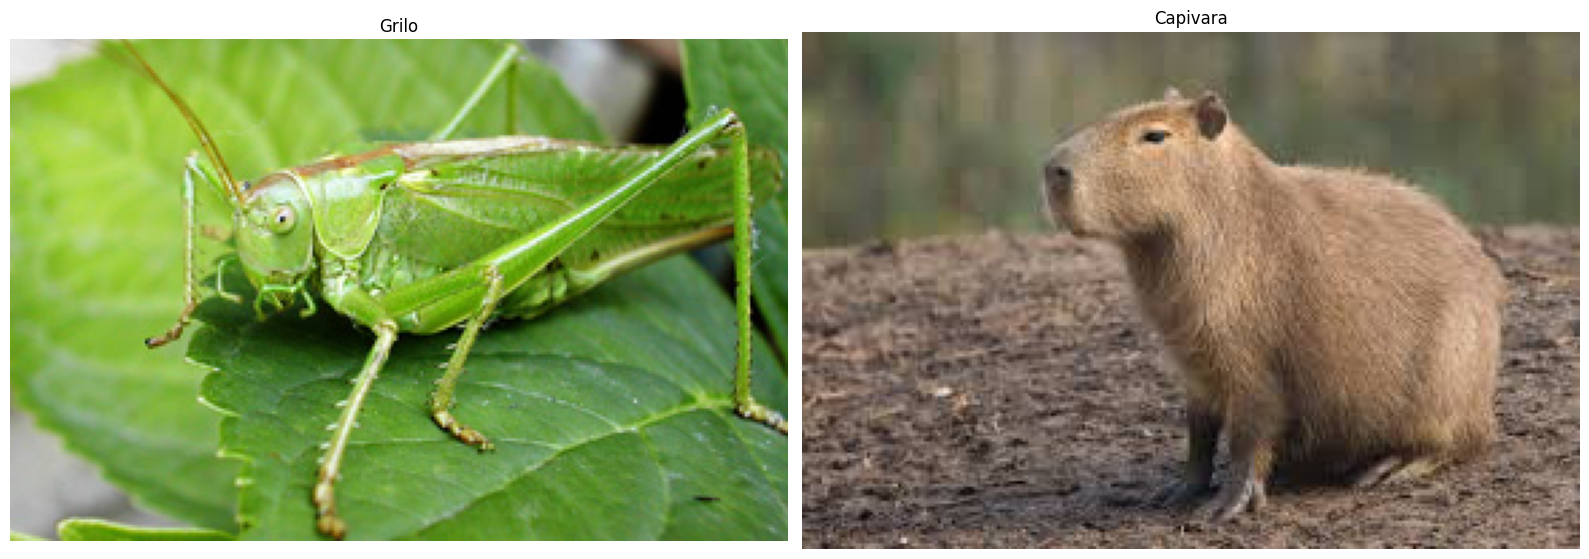

In [28]:
imgG = Image.open('grilo.jpg')
imgC = Image.open('capivara.jpg')

exibe_mosaico([imgG, imgC], ['Grilo', 'Capivara'])

### ***Obs.:**

- Note que, quando trabalhamos com histogramas, normalmente não nos preocupamos com os tamanhos das dimensões das imagens utilizadas, não exigindo que as duas imagens tenham o mesmo tamanho, apenas a mesma quantidade de dimensões.

### Ilustrando a técnica

1. Computando os histogramas de cada imagem

In [29]:
Cg = histograma(imgG, tipo='c')
Cc = histograma(imgC, tipo='c')

2. Calculando mapeamentos

- Vamos criar, para cada canal (R, G, B e Cinza), um mapeamento do tom da imagem alvo para o tom correspondente, vindo da imagem de estilo

- O mapa terá a forma $4 \times 256$, pois são $4$ canais distintos e depois, para cada um dos $256$ níveis possíveis, para qual valor será mapeado

In [30]:
mapa = np.zeros((4, 256))
for c in range(4):
  for k in range(256):
    # Obtém CDF da imagem alvo
    p = Cg[c,k]
    # Computa a diferença de todas CDF da imagem de estilo para a da imagem alvo
    diff = np.abs(Cc[c] - p)
    # Identifica a posição de menor diferença e salva no mapa
    mapa[c,k] = np.argmin(diff)

3. Aplicando mapeamentos

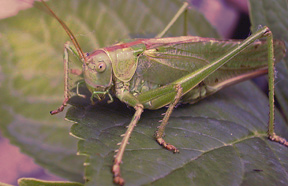

In [31]:
arrG = np.asarray(imgG).astype(int)
arrEsp = np.zeros_like(arrG)

for i in range(arrG.shape[0]):
  for j in range(arrG.shape[1]):
    r,g,b = arrG[i,j]
    arrEsp[i,j] = [mapa[0,r], mapa[1,g], mapa[2,b]]

display(gera_imagem(arrEsp))

Condensando tudo em uma função:

In [32]:
def especifica_histograma(imgForma, imgEstilo):
  Cf = histograma(imgForma, tipo='c')
  Ce = histograma(imgEstilo, tipo='c')

  # Não vamos considerar o "canal" cinza
  mapa = np.zeros((3, 256))
  for c in range(3):
    for k in range(256):
      p = Cf[c,k]
      diff = np.abs(Ce[c] - p)
      mapa[c,k] = np.argmin(diff)

  arrF = np.asarray(imgForma).astype(int)
  arrEsp = np.zeros_like(arrF)

  for i in range(arrF.shape[0]):
    for j in range(arrF.shape[1]):
      r,g,b = arrF[i,j]
      arrEsp[i,j] = [mapa[0,r], mapa[1,g], mapa[2,b]]

  return gera_imagem(arrEsp)

#### **Testando a solução**

In [33]:
imgEspGC = especifica_histograma(imgG, imgC)
imgEspCG = especifica_histograma(imgC, imgG)

imgs = [imgG, imgC, imgEspGC, imgEspCG]
legs = ['Grilo', 'Capivara', 'Grilo <-- Capivara', 'Capivara <-- Grilo']
exibe_mosaico(imgs, legs)

Output hidden; open in https://colab.research.google.com to view.

- Vamos padronizar essa visualização em uma função:

In [34]:
def estilos(arqA, arqB):
  imgA = Image.open(arqA)
  imgB = Image.open(arqB)

  imgEspAB = especifica_histograma(imgA, imgB)
  imgEspBA = especifica_histograma(imgB, imgA)

  imgs = [imgA, imgB, imgEspAB, imgEspBA]
  legs = [arqA, arqB, arqA + ' <-- ' + arqB, arqB + ' <-- ' + arqA]
  exibe_mosaico(imgs, legs)

- Mais testes:

In [35]:
estilos('hindu.jpg', 'favela.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [36]:
estilos('antiga03.jpg', 'capivara_salto.png')

Output hidden; open in https://colab.research.google.com to view.

In [37]:
# Produzindo uma imagem cinza em formato RGB
imgCap = Image.open('capivara_salto.png')
arrCapCinza = cinza_lum(imgCap)
arrCapCinza = np.dstack((arrCapCinza, arrCapCinza, arrCapCinza))
imgCapCinza = gera_imagem(arrCapCinza)

imgCapCinza.save('capivara_salto_cinza.png')

In [38]:
estilos('antiga03.jpg', 'capivara_salto_cinza.png')

Output hidden; open in https://colab.research.google.com to view.

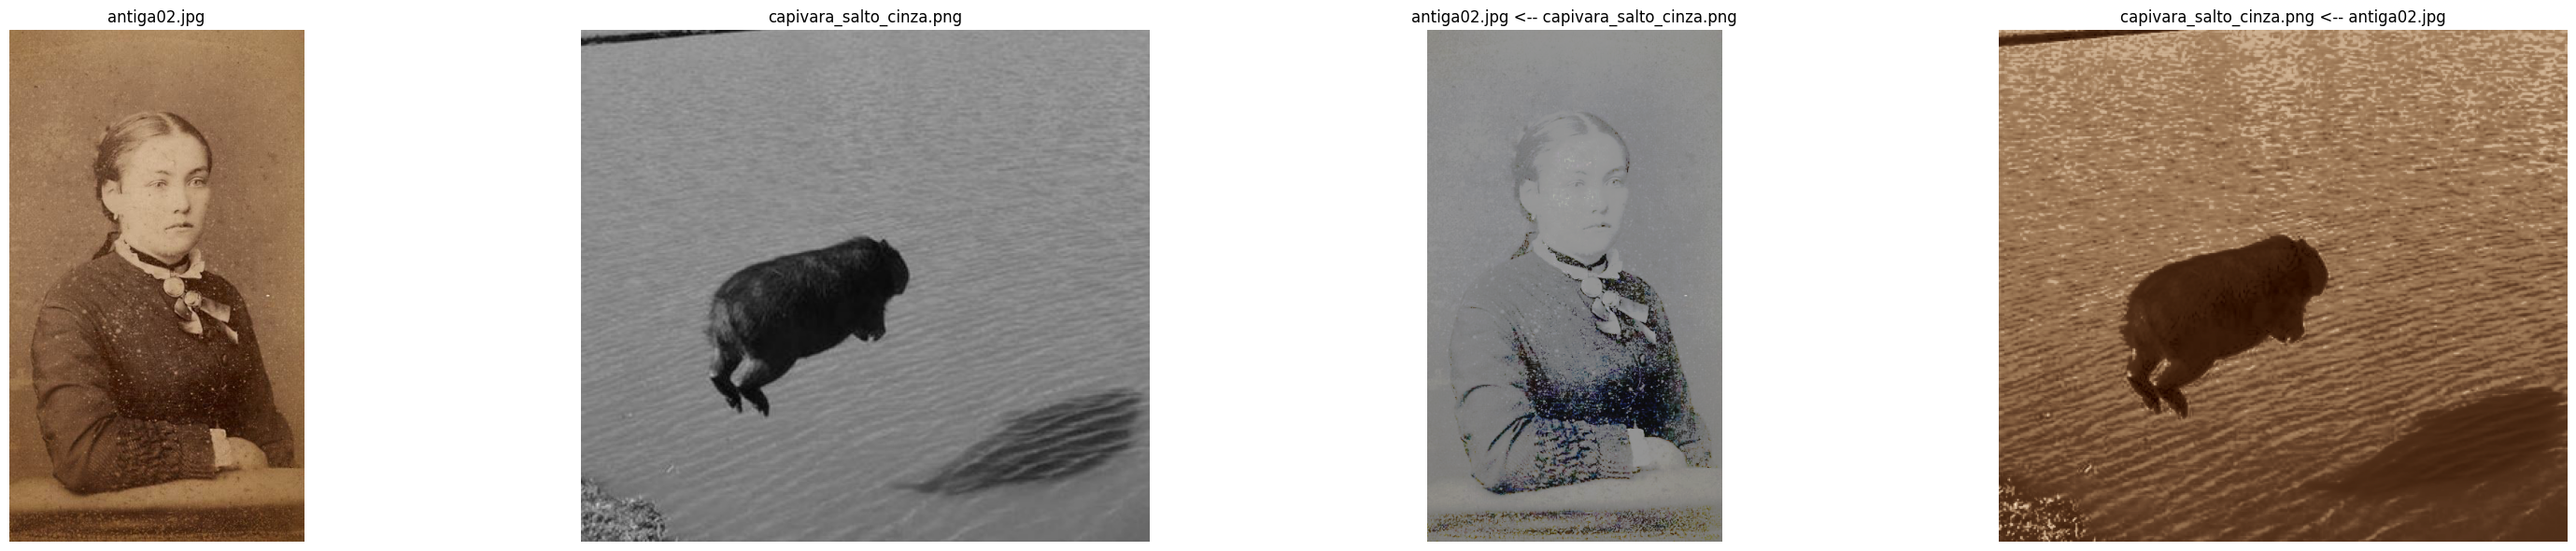

In [39]:
estilos('antiga02.jpg', 'capivara_salto_cinza.png')

In [40]:
estilos('antiga04.jpg', 'capivara_salto_cinza.png')

Output hidden; open in https://colab.research.google.com to view.

In [41]:
estilos('grilo.jpg', 'hindu.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [42]:
estilos('antiga03.jpg', 'coco.png')

Output hidden; open in https://colab.research.google.com to view.

In [43]:
estilos('antiga03.jpg', 'antiga01.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [44]:
estilos('antiga01.jpg', 'bh2.png')

Output hidden; open in https://colab.research.google.com to view.

In [45]:
estilos('capivara_salto_cinza.png', 'bh2.png')

Output hidden; open in https://colab.research.google.com to view.

In [46]:
estilos('capivara_salto.png', 'bh2.png')

Output hidden; open in https://colab.research.google.com to view.

In [47]:
arquivos = [
    'ufv_escuro.jpg',
    'ufv_crepusculo.png',
    'ufv_claro.jpg',
    'ufv_noite.jpg'
    ]

for i in range(len(arquivos)-1):
  for j in range(i+1, len(arquivos)):
    estilos(arquivos[i], arquivos[j])

Output hidden; open in https://colab.research.google.com to view.